# <span style='color:blue'><center>Kernel SVM</center></span>

When the data is not linearly separable, the dimension of the system could be extended even further by adding new features that represent higher order polinomials or non-linear functions. The main idea is that if the system is not linear in the original space, it is driven to a higher dimensional space where the data could be linearly separable, there an usual perceptron or SVM technique would work just fine.

A kernel function could be defined to resume all this process, with an additional advantage: instead of performing operations in a very high dimensional space (which clearly consumes a lot of computing time and scales quickly depending on the chosen dimensionality), this simple expression (kernel function) is evaluated for each datapoint. Not any function can be chosen as a kernel, it needs to fulfill Mercer's rule, that is, this function must represent a dot product in some higher dimensional space. 

In [1]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm

In [53]:
def cross_validation_error(x,y,C_value,k, maxiter):
    n = len(y)
    ## Randomly shuffle indices
    indices = np.random.permutation(n)
    
    ## Initialize error
    err = 0.0
    
    ## Iterate over partitions
    for i in range(k):
        ## Partition indices
        test_indices = indices[int(i*(n/k)):int((i+1)*(n/k) - 1)]
        train_indices = np.setdiff1d(indices, test_indices)
        
        ## Train classifier with parameter c
        clf = svm.LinearSVC(C=C_value, loss='hinge', max_iter = maxiter)
        clf.fit(x[train_indices], y[train_indices])
        
        ## Get predictions on test partition
        preds = clf.predict(x[test_indices])
        
        ## Compute error
        err += float(np.sum((preds > 0.0) != (y[test_indices] > 0.0)))/len(test_indices)
        
    return err/k

In [52]:
def choose_parameter(x, y, k, max_iter):
    cvals = [0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
    
    all_errors = list()

    for some_c in cvals:
        error = cross_validation_error(x, y, some_c, k, max_iter)
        all_errors.append(error)
    
    mindx = np.argmin(all_errors)
    
    min_cross_error = all_errors[mindx]
    best_c_value = cvals[mindx]
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(np.array(cvals), all_errors, color='lawngreen', marker='*', label = 'Cross-validation error')
    ax1.set_xscale('log')
    plt.legend(loc="best")
    ax1.set_xlabel('C value')
    ax1.set_ylabel('Error')
    plt.grid()
    plt.show()
    
    return best_c_value, min_cross_error

In [125]:
def plot_classification_map(clf, data, color_at, marker_at, label_names):
    # To plot a 2-D map of the data separated by linear boundaries
    differ_labels = np.unique( data[:,2] )
    x_range = np.linspace( np.min(data[:,0]), np.max(data[:, 0]), 1000 )

    plt.figure()
    x1_range = np.arange( np.min(data[:,0])-1, np.max(data[:, 0])+1 , 0.05 )
    x2_range = np.arange( np.min(data[:,1])-1, np.max(data[:, 1])+1 , 0.05 )
    X1_space, X2_space  = np.meshgrid( x1_range, x2_range )

    grid = np.c_[X1_space.ravel(), X2_space.ravel()]


    Z = np.array([clf.predict( np.array([[point[0]],[point[1]]]).reshape(-1,1).T ) for point in grid])
    Z = Z.reshape(X1_space.shape)
    plt.pcolormesh(X1_space, X2_space, Z, cmap=plt.cm.Pastel1, vmin=0, vmax=1+np.max(data[:,2]))
    each_class = 0
    
    sv = np.zeros(data.shape[0], dtype=bool)
    sv[clf.support_] = True
    
    
    for da_class in differ_labels:
        class_1_points = data[ ((data[:,2]== da_class) & (sv==False)) , :] 
        plt.scatter( class_1_points[:, 0], class_1_points[:, 1], c=color_at[each_class], 
                    marker=marker_at[each_class], label='{}'.format(label_names[each_class]), s = 20)
        
        class_1_points = data[ ((data[:,2]== da_class) & (sv==True)) , :] 
        plt.scatter( class_1_points[:, 0], class_1_points[:, 1], c=color_at[each_class], 
                    marker=marker_at[each_class], label='{}'.format(label_names[each_class]), s = 70)
        each_class = each_class + 1
    

    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.legend(loc='best')
    plt.show()

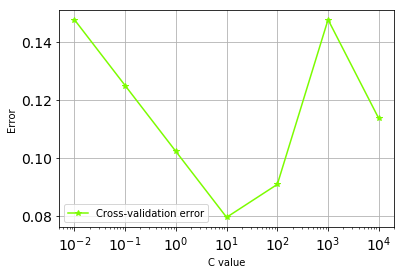

In [126]:
data = np.loadtxt('data3.txt')
train_set = data[:,0:2]
train_labels = data[:,2]
c, err = choose_parameter(train_set, train_labels, 2, 10000000)

In [127]:
clf1 = svm.SVC(kernel='poly', degree = 2, C = c, coef0 = 1, max_iter=10000, gamma = 'auto')
clf1.fit(train_set, train_labels)

clf2 = svm.SVC(kernel='rbf', C = c, coef0 = 1, max_iter=10000, gamma = 'auto')
clf2.fit(train_set, train_labels)

/home/cristian/.local/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=10.0, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Using a second order polynomial kernel: 


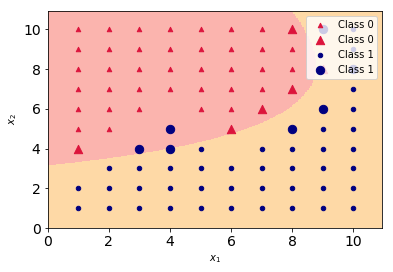

Accuracy:  0.9666666666666667
Using the Radial Basis Function (RBF): 


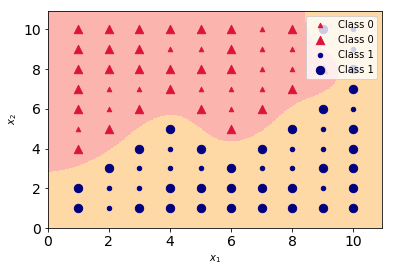

Accuracy:  1.0


In [128]:
color_at = ['crimson', 'navy', 'lime', 'black']
marker_at = ['^', 'o', 's', 'd']
label_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print('Using a second order polynomial kernel: ')
plot_classification_map(clf1, data, color_at, marker_at, label_names)
print('Accuracy: ', clf1.score(train_set, train_labels))
print('Using the Radial Basis Function (RBF): ')
plot_classification_map(clf2, data, color_at, marker_at, label_names)
print('Accuracy: ', clf2.score(train_set, train_labels))

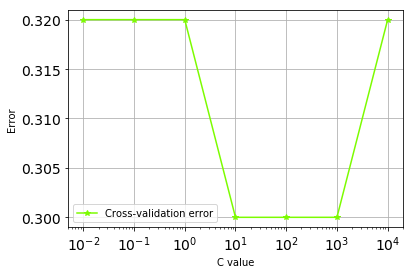

In [147]:
data = np.loadtxt('data1.txt')
train_set = data[:,0:2]
train_labels = data[:,2]
c, err = choose_parameter(train_set, train_labels, 2, 1000000)

In [148]:
clf1 = svm.SVC(kernel='poly', degree = 2, C = c, coef0 = 1, max_iter=100000, gamma = 'auto')
clf1.fit(train_set, train_labels)

clf2 = svm.SVC(kernel='rbf', C = c, coef0 = 1, max_iter=100000, gamma = 'auto')
clf2.fit(train_set, train_labels)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=100000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Using a second order polynomial kernel: 


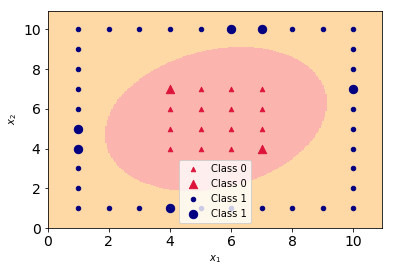

Accuracy:  1.0
Using the Radial Basis Function (RBF): 


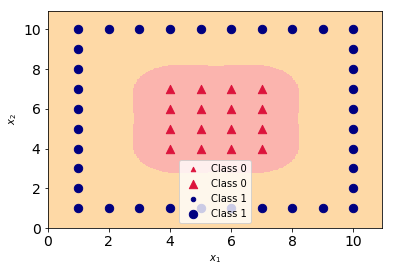

Accuracy:  1.0


In [149]:
color_at = ['crimson', 'navy', 'lime', 'black']
marker_at = ['^', 'o', 's', 'd']
label_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print('Using a second order polynomial kernel: ')
plot_classification_map(clf1, data, color_at, marker_at, label_names)
print('Accuracy: ', clf1.score(train_set, train_labels))
print('Using the Radial Basis Function (RBF): ')
plot_classification_map(clf2, data, color_at, marker_at, label_names)
print('Accuracy: ', clf2.score(train_set, train_labels))